In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=3)

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# sk dependencies
import sklearn

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize
from pymoo.core.termination import NoTermination

from pymoo.core.problem import Problem

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('Results_Algo1_Run15.csv')

BATCH_SIZE = 4

n_var = 5
n_obj = 3
n_constr = 2

random_state = 1
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([0, 0, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point)

for current_iter in (1, 5, 10, 15):
#current_iter = 15 

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]

    ####################
    # normalization

    # normalize inputs to [0,1] first before feeding into model
    problem_bounds = torch.zeros(2, n_var, **tkwargs)
    problem_bounds[0] = 0.6
    problem_bounds[1] = 24.0

    standard_bounds = torch.zeros(2, n_var, **tkwargs)
    standard_bounds[1] = 1

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',') 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',') 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    
    # acquisition function

    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(n_obj, n_obj+n_constr)]

    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
        constraints=create_idxrs(), # constraint on last n_constr col
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

    candidates1 = draw_sobol_samples(bounds=standard_bounds,n=256, q=1).squeeze(1)
    candidates2 = draw_sobol_samples(bounds=standard_bounds,n=256, q=1).squeeze(1)
    candidates = torch.vstack([candidates1, candidates2])


    acq_list, ypred_list, errdown_list, errup_list = [], [], [], []

    model.eval();

    for i in range(0, candidates.shape[0]):
        with torch.no_grad():
            acq_value = acq_func(candidates[i].unsqueeze(dim=0))
            acq_list.append(acq_value.item())

            posterior = model.posterior(candidates[i].unsqueeze(0))

            y_pred = posterior.mean
            ypred_list.append(y_pred[0].cpu().numpy())

            lower, upper = posterior.mvn.confidence_region()
            errdown_list.append(lower[0].cpu().numpy())
            errup_list.append(upper[0].cpu().numpy())

    acq_plot = np.array(acq_list)
    ypred_plot = np.array(ypred_list)
    errdown_plot = np.array(errdown_list)
    errup_plot = np.array(errup_list)

    max_acq = ypred_plot[acq_plot.argsort()[:BATCH_SIZE]]

    norm = plt.Normalize(acq_plot.min(), acq_plot.max())

    views = [(1, (0, -45, 0)),
             (2, (0, 45, 0)),
             (3, (0, 135, 0)),]
    layout = [[1, 2, 3]]  

    fig, ax = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                                  figsize=(21, 7))

    for plane, angles in views:

        ax[plane].scatter3D(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                            c=acq_plot, s=20, norm=norm, cmap='viridis', alpha=0.15)

        ax[plane].scatter3D(max_acq[:,0], max_acq[:,1], max_acq[:,2],
                            c='r', marker='*', s=100, alpha=0.9)

        ax[plane].scatter3D(train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,0].cpu().numpy(), 
                            train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,1].cpu().numpy(),
                            train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,2].cpu().numpy(),
                            c='b', marker='*', s=100, alpha=0.9)

        ax[plane].set_xlabel('f1', fontsize=11)
        ax[plane].set_ylabel('f2', fontsize=11)
        ax[plane].set_zlabel('f3', fontsize=11)

        ax[plane].set_xlim(0, 1)
        ax[plane].set_ylim(0, 0.055)
        ax[plane].set_zlim(0, 1)

        ax[plane].view_init(azim=angles[1])

    ax[2].set_title(f"Predicted Results w/ AcqValue for Algo 1, Iteration {current_iter}", fontsize=18)

    fig, ax = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                                  figsize=(21, 7))

    for plane, angles in views:

        ax[plane].errorbar(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                           xerr=errup_plot[:,0]-errdown_plot[:,0],
                           yerr=errup_plot[:,1]-errdown_plot[:,1],
                           zerr=errup_plot[:,2]-errdown_plot[:,2],
                           c='b', alpha=0.05)

        ax[plane].scatter3D(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                            c='b', s=20, alpha=0.4)


        ax[plane].set_xlabel('f1', fontsize=11)
        ax[plane].set_ylabel('f2', fontsize=11)
        ax[plane].set_zlabel('f3', fontsize=11)

        ax[plane].set_xlim(0, 1)
        ax[plane].set_ylim(0, 0.055)
        ax[plane].set_zlim(0, 1)

        ax[plane].view_init(azim=angles[1])

    ax[2].set_title(f"Uncertainty for Algo 1, Iteration {current_iter}", fontsize=18)

TypeError: __init__() missing 1 required positional argument: 'sample_shape'

C:\Users\user\AppData\Local\Temp\ipykernel_59996\2859529104.py:98: DeprecationWarning: Call to deprecated function (or staticmethod) get_reference_directions. (Please use `from pymoo.util.ref_dirs import get_reference_directions`)
  ref_dirs=get_reference_directions("energy", n_obj, BATCH_SIZE, seed=random_state),
C:\Users\user\AppData\Local\Temp\ipykernel_59996\2859529104.py:98: DeprecationWarning: Call to deprecated function (or staticmethod) get_reference_directions. (Please use `from pymoo.util.ref_dirs import get_reference_directions`)
  ref_dirs=get_reference_directions("energy", n_obj, BATCH_SIZE, seed=random_state),
C:\Users\user\AppData\Local\Temp\ipykernel_59996\2859529104.py:98: DeprecationWarning: Call to deprecated function (or staticmethod) get_reference_directions. (Please use `from pymoo.util.ref_dirs import get_reference_directions`)
  ref_dirs=get_reference_directions("energy", n_obj, BATCH_SIZE, seed=random_state),
C:\Users\user\AppData\Local\Temp\ipykernel_59996\285

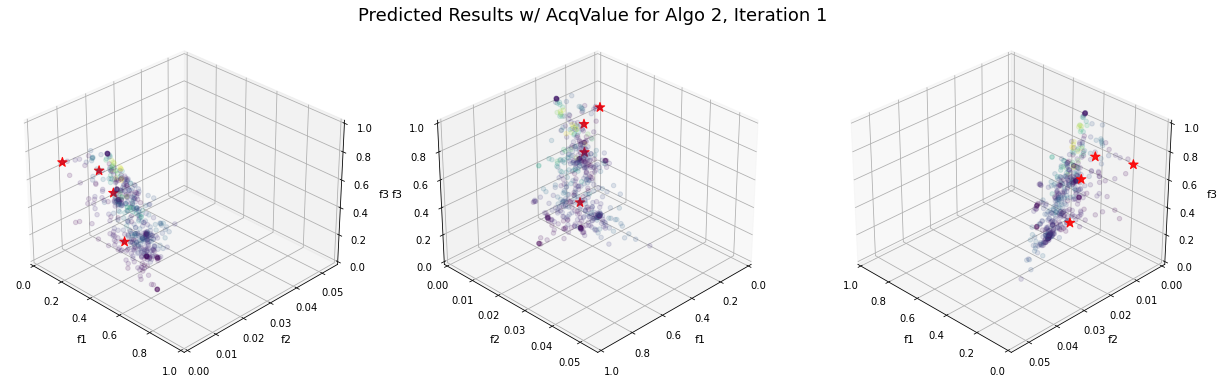

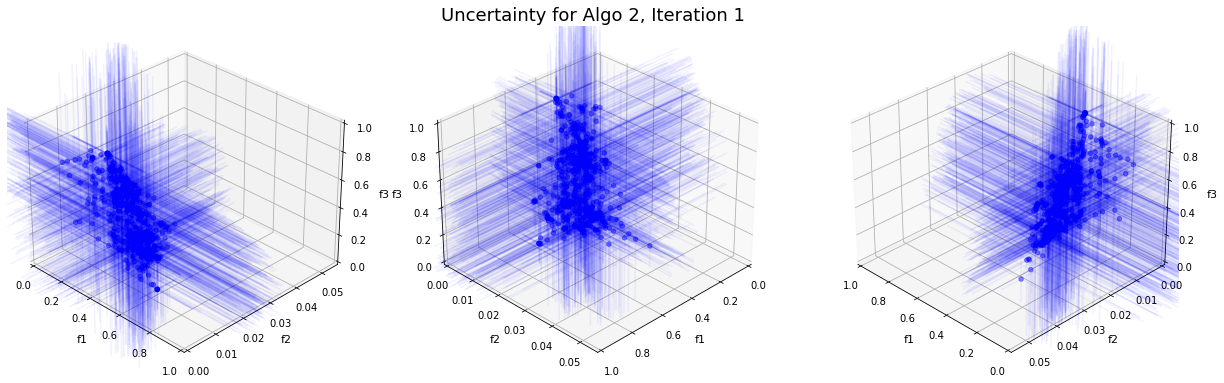

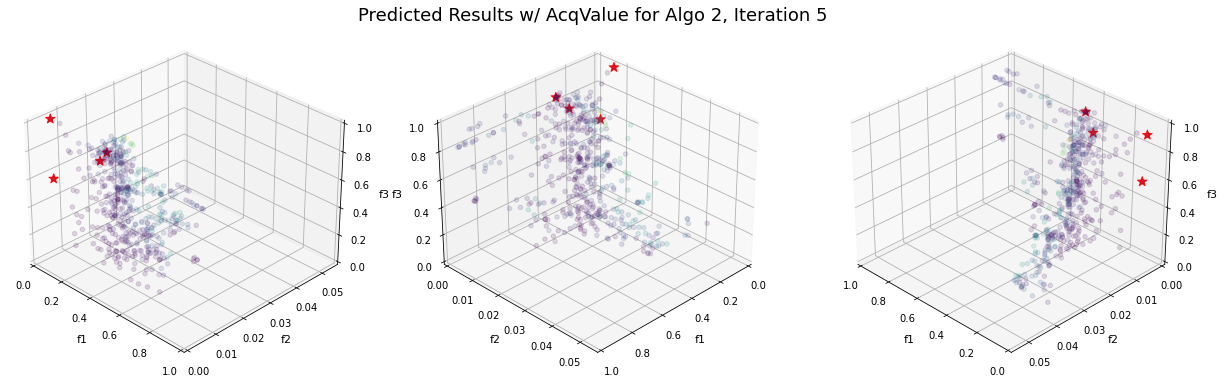

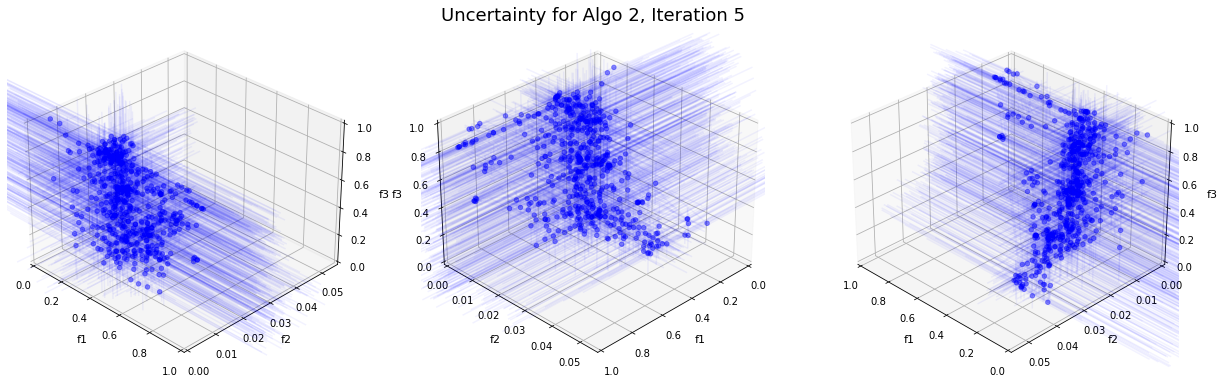

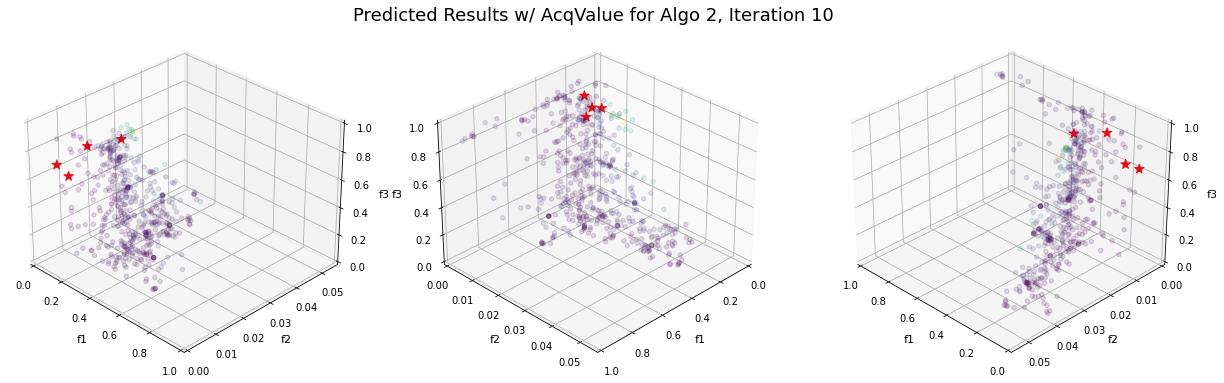

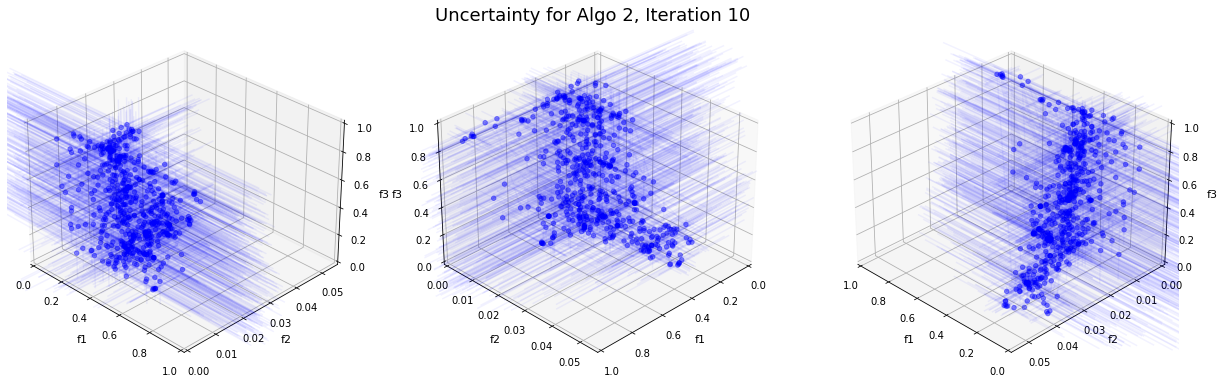

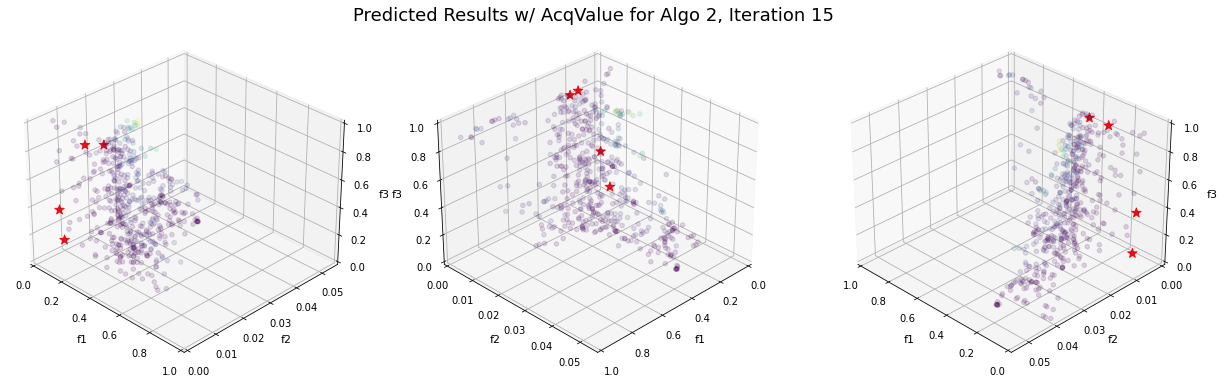

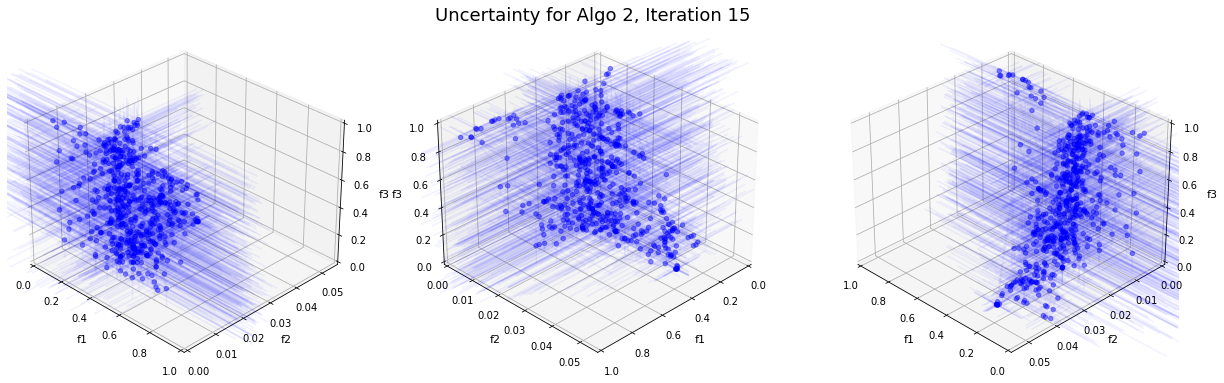

In [3]:
df = pd.read_csv('Results_Algo2_Run15.csv')

BATCH_SIZE = 4

n_var = 5
n_obj = 3
n_constr = 2

random_state = 1
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([0, 0, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point)

for current_iter in (1, 5, 10, 15):
#current_iter = 15 

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]

    ####################
    # normalization

    # normalize inputs to [0,1] first before feeding into model
    problem_bounds = torch.zeros(2, n_var, **tkwargs)
    problem_bounds[0] = 0.6
    problem_bounds[1] = 24.0

    standard_bounds = torch.zeros(2, n_var, **tkwargs)
    standard_bounds[1] = 1

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',') 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',') 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    
    # acquisition function

    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(n_obj, n_obj+n_constr)]

    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
        constraints=create_idxrs(), # constraint on last n_constr col
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

    candidates1 = draw_sobol_samples(bounds=standard_bounds,n=256, q=1).squeeze(1)

    # we pick out the best points so far to form parents
    pareto_mask = is_non_dominated(train_obj)
    pareto_y = -train_obj[pareto_mask]
    pareto_x = train_x_gp[pareto_mask]
    pareto_con = train_con[pareto_mask]

    algorithm = UNSGA3(pop_size=256,
                       ref_dirs=get_reference_directions("energy", n_obj, BATCH_SIZE, seed=random_state),
                       sampling=pareto_x.cpu().numpy(),
                       #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                       #mutation=PolynomialMutation(eta=20, prob=None),
                      )

    pymooproblem = Problem(n_var=n_var, n_obj=n_obj, n_constr=n_constr, 
                  xl=np.zeros(n_var), xu=np.ones(n_var))

    algorithm.setup(pymooproblem, termination=NoTermination())

    # set the 1st population to the current evaluated population
    pop = algorithm.ask()
    pop.set("F", pareto_y.cpu().numpy())
    pop.set("G", pareto_con.cpu().numpy())
    algorithm.tell(infills=pop)

    # propose children based on tournament selection -> crossover/mutation
    newpop = algorithm.ask()
    nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
    
    candidates = torch.vstack([candidates1, nsga3_x])
    
    
    
    
    acq_list, ypred_list, errdown_list, errup_list = [], [], [], []

    model.eval();

    for i in range(0, candidates.shape[0]):
        with torch.no_grad():
            acq_value = acq_func(candidates[i].unsqueeze(dim=0))
            acq_list.append(acq_value.item())

            posterior = model.posterior(candidates[i].unsqueeze(0))

            y_pred = posterior.mean
            ypred_list.append(y_pred[0].cpu().numpy())

            lower, upper = posterior.mvn.confidence_region()
            errdown_list.append(lower[0].cpu().numpy())
            errup_list.append(upper[0].cpu().numpy())

    acq_plot = np.array(acq_list)
    ypred_plot = np.array(ypred_list)
    errdown_plot = np.array(errdown_list)
    errup_plot = np.array(errup_list)

    max_acq = ypred_plot[acq_plot.argsort()[:BATCH_SIZE]]

    norm = plt.Normalize(acq_plot.min(), acq_plot.max())

    views = [(1, (0, -45, 0)),
             (2, (0, 45, 0)),
             (3, (0, 135, 0)),]
    layout = [[1, 2, 3]]  

    fig, ax = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                                  figsize=(21, 7))

    for plane, angles in views:

        ax[plane].scatter3D(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                            c=acq_plot, s=20, norm=norm, cmap='viridis', alpha=0.15)

        ax[plane].scatter3D(max_acq[:,0], max_acq[:,1], max_acq[:,2],
                            c='r', marker='*', s=100, alpha=0.9)

        ax[plane].scatter3D(train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,0].cpu().numpy(), 
                            train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,1].cpu().numpy(),
                            train_obj[12+(current_iter-1)*BATCH_SIZE:12+(current_iter)*BATCH_SIZE,2].cpu().numpy(),
                            c='b', marker='*', s=100, alpha=0.9)

        ax[plane].set_xlabel('f1', fontsize=11)
        ax[plane].set_ylabel('f2', fontsize=11)
        ax[plane].set_zlabel('f3', fontsize=11)

        ax[plane].set_xlim(0, 1)
        ax[plane].set_ylim(0, 0.055)
        ax[plane].set_zlim(0, 1)

        ax[plane].view_init(azim=angles[1])

    ax[2].set_title(f"Predicted Results w/ AcqValue for Algo 2, Iteration {current_iter}", fontsize=18)

    fig, ax = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                                  figsize=(21, 7))

    for plane, angles in views:

        ax[plane].errorbar(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                           xerr=errup_plot[:,0]-errdown_plot[:,0],
                           yerr=errup_plot[:,1]-errdown_plot[:,1],
                           zerr=errup_plot[:,2]-errdown_plot[:,2],
                           c='b', alpha=0.05)

        ax[plane].scatter3D(ypred_plot[:,0], ypred_plot[:,1], ypred_plot[:,2],
                            c='b', s=20, alpha=0.4)


        ax[plane].set_xlabel('f1', fontsize=11)
        ax[plane].set_ylabel('f2', fontsize=11)
        ax[plane].set_zlabel('f3', fontsize=11)

        ax[plane].set_xlim(0, 1)
        ax[plane].set_ylim(0, 0.055)
        ax[plane].set_zlim(0, 1)

        ax[plane].view_init(azim=angles[1])

    ax[2].set_title(f"Uncertainty for Algo 2, Iteration {current_iter}", fontsize=18)

In [6]:
BATCH_SIZE = 4
n_var = 5
n_obj = 3
n_constr = 2

df1 = pd.read_csv('Results_Algo1_Run15.csv')
df2 = pd.read_csv('Results_Algo2_Run15.csv')

df_all = pd.concat([df1, df2])
df_all = df_all.reset_index(drop=True)
df_all = df_all.iloc[:, 1:]

####################
# normalization

# normalize inputs to [0,1] first before feeding into model
problem_bounds = torch.zeros(2, n_var, **tkwargs)
problem_bounds[0] = 0.6
problem_bounds[1] = 24.0

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

train_x_all = torch.tensor(df_all.iloc[:,:n_var].values, **tkwargs)
train_x_all_gp = normalize(train_x_all, problem_bounds)
train_y_all = torch.tensor(df_all.iloc[:,n_var:n_var+n_obj+n_constr].values, **tkwargs)

####################
# testing for constraints
fake_x = draw_sobol_samples(bounds=problem_bounds,n=1024, q=1).squeeze(1)
fake_x_gp = normalize(fake_x, problem_bounds)
fake_y1 = 0.3 - fake_x[:,1]/fake_x[:,4]
fake_y2 = 2 - (fake_x[:,1]/fake_x[:,4]) - (fake_x[:,3]/fake_x[:,1])
fake_y = torch.hstack([fake_y1.unsqueeze(1), fake_y2.unsqueeze(1)])

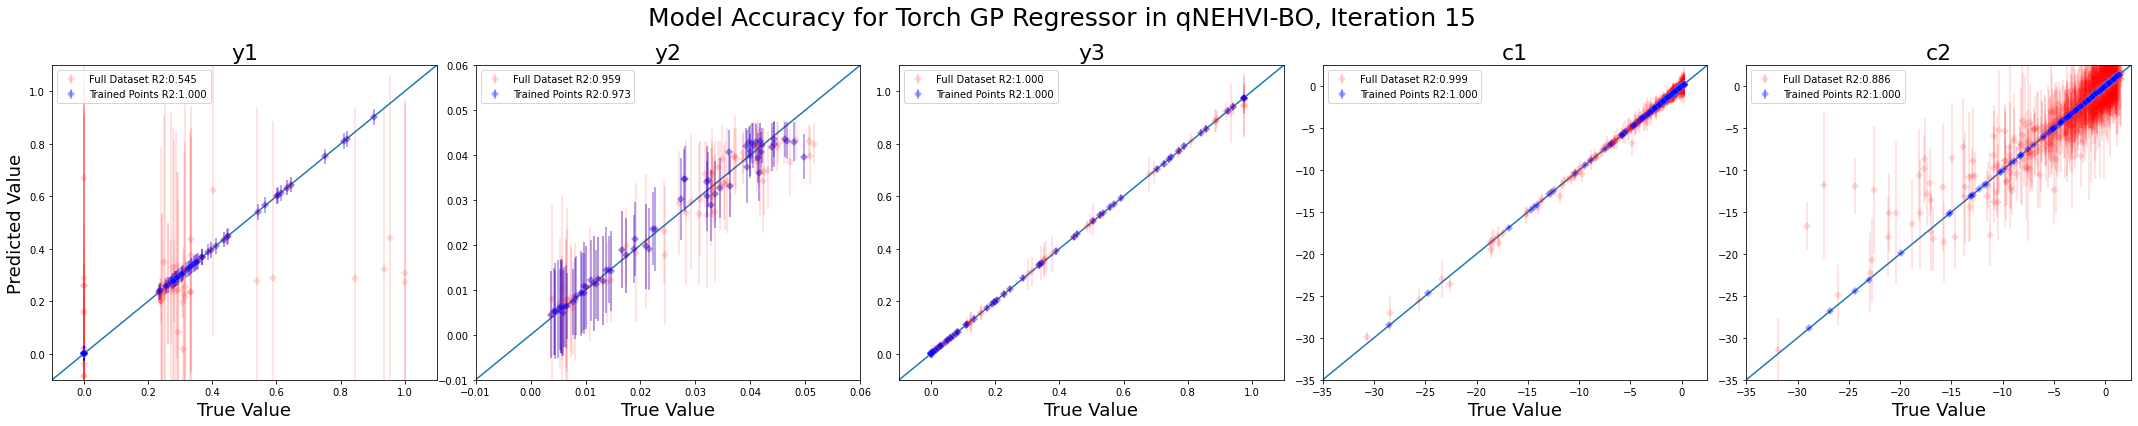

In [21]:
df = pd.read_csv('Results_Algo1_Run15.csv')

r2_list1,r2_list2,r2_list3,r2_list4,r2_list5 = [],[],[],[],[]

for current_iter in range(15,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]
    
    train_y = torch.hstack([train_obj, train_con])

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    

    model.eval();

    with torch.no_grad():
        # entire dataset
        posterior = model.posterior(train_x_all_gp)
        y_pred = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error = upper-lower
        
        # just the training set
        posterior = model.posterior(train_x_gp)
        y_pred1 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error1 = upper-lower
        
        # constraint - pre-trained added 256
        posterior = model.posterior(virtual_x_gp1)
        y_pred2 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error2 = upper-lower

        # constraint - testing on 1024
        posterior = model.posterior(fake_x_gp)
        y_pred3 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error3 = upper-lower    
        
    # record r2 scores for objective values
    for i,r2list in zip([0,1,2],
                        [r2_list1,r2_list2,r2_list3]
                        ):
        full_score = r2_score(train_y_all[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        train_score = r2_score(train_y[:,i].cpu().numpy(), y_pred1[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])
    
    # record r2 scores for constraint values
    for i, j, r2list in zip([3,4],
                            [0,1],
                            [r2_list4,r2_list5]
                           ):
        
        full_score = r2_score(fake_y[:,j].cpu().numpy(), y_pred3[:,i].cpu().numpy())
        train_score = r2_score(virtual_con1[:,j].cpu().numpy(), y_pred2[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])

    ####################
       
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
            
        fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

        # plot objective predictions
        for i, obj, r2 in zip([0,1,2],
                          ['y1', 'y2', 'y3'], [r2_list1,r2_list2,r2_list3],
                          ):

            ax[i].axline((1, 1), slope=1)

            ax[i].errorbar(x=train_y_all[:,i].cpu().numpy(), y=y_pred[:,i].cpu().numpy(), yerr=error[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label=f'Full Dataset R2:{r2[0][0]:.3f}'
                           )
            
            ax[i].errorbar(x=train_y[:,i].cpu().numpy(), y=y_pred1[:,i].cpu().numpy(), yerr=error1[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                            label=f'Trained Points R2:{r2[0][1]:.3f}'
                           )            
            

            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
            ax[i].legend()
         
        # plot constraint predictions
        for i, j,  obj, r2 in zip([3,4],
                              [0,1],
                              ['c1', 'c2'], [r2_list4,r2_list5]
                             ):

            ax[i].axline((1, 1), slope=1)

            # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
            ax[i].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label=f'Full Dataset R2:{r2[0][0]:.3f}'
                           )

            # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
            ax[i].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                        label=f'Trained Points R2:{r2[0][1]:.3f}'
                       )          
            
            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
            ax[i].legend()

        # some settings for the overall plotting
        ax[0].set_ylabel('Predicted Value', fontsize=18)
        fig.suptitle(f'Model Accuracy for Torch GP Regressor in qNEHVI-BO, Iteration {current_iter}', fontsize=25)
        fig.tight_layout()

        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_ylim(-0.1, 1.1)
        
        ax[1].set_xlim(-0.01, 0.06)
        ax[1].set_ylim(-0.01, 0.06)
        
        ax[2].set_xlim(-0.1, 1.1)
        ax[2].set_ylim(-0.1, 1.1)
        
        ax[3].set_xlim(-35, 2.5)
        ax[3].set_ylim(-35, 2.5)
        
        ax[4].set_xlim(-35, 2.5)
        ax[4].set_ylim(-35, 2.5)

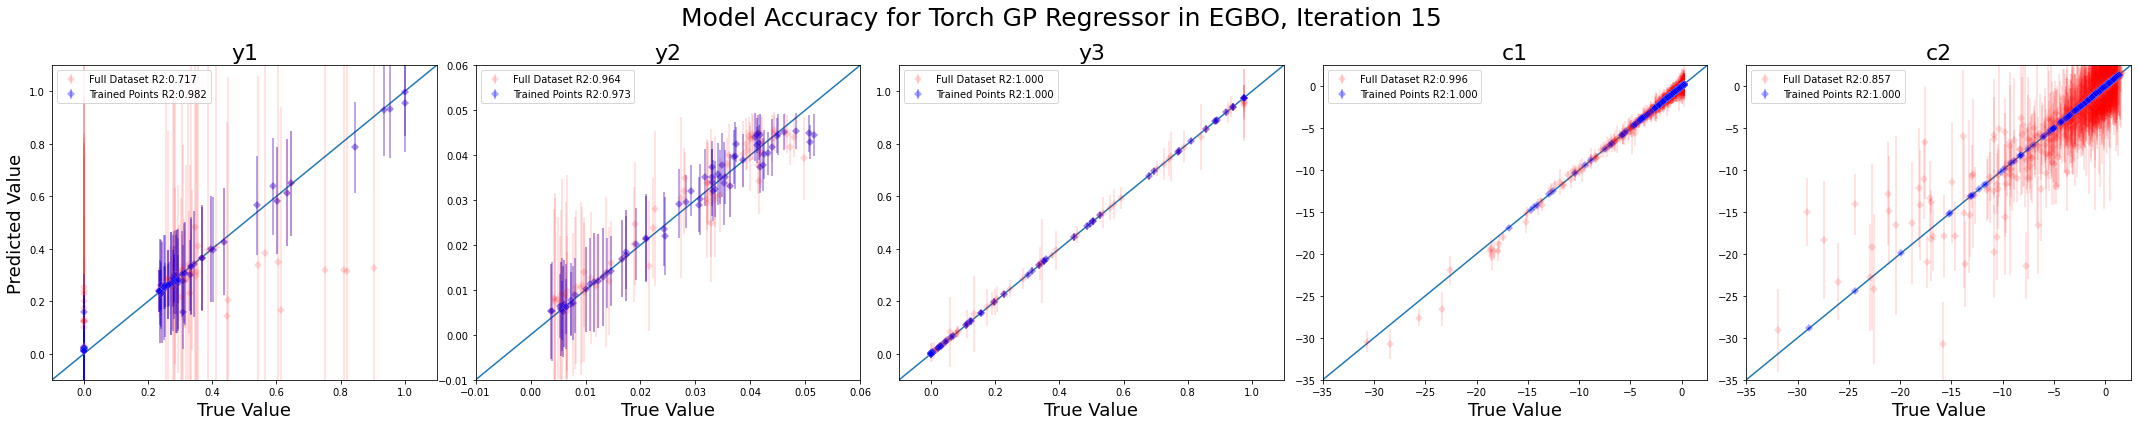

In [22]:
df = pd.read_csv('Results_Algo2_Run15.csv')

r2_list1,r2_list2,r2_list3,r2_list4,r2_list5 = [],[],[],[],[]

for current_iter in range(15,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]
    
    train_y = torch.hstack([train_obj, train_con])

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    

    model.eval();

    with torch.no_grad():
        # entire dataset
        posterior = model.posterior(train_x_all_gp)
        y_pred = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error = upper-lower
        
        # just the training set
        posterior = model.posterior(train_x_gp)
        y_pred1 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error1 = upper-lower
        
        # constraint - pre-trained added 256
        posterior = model.posterior(virtual_x_gp1)
        y_pred2 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error2 = upper-lower

        # constraint - testing on 1024
        posterior = model.posterior(fake_x_gp)
        y_pred3 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error3 = upper-lower    
        
    # record r2 scores for objective values
    for i,r2list in zip([0,1,2],
                        [r2_list1,r2_list2,r2_list3]
                        ):
        full_score = r2_score(train_y_all[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        train_score = r2_score(train_y[:,i].cpu().numpy(), y_pred1[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])
    
    # record r2 scores for constraint values
    for i, j, r2list in zip([3,4],
                            [0,1],
                            [r2_list4,r2_list5]
                           ):
        
        full_score = r2_score(fake_y[:,j].cpu().numpy(), y_pred3[:,i].cpu().numpy())
        train_score = r2_score(virtual_con1[:,j].cpu().numpy(), y_pred2[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])

    ####################
       
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
            
        fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

        # plot objective predictions
        for i, obj, r2 in zip([0,1,2],
                          ['y1', 'y2', 'y3'], [r2_list1,r2_list2,r2_list3],
                          ):

            ax[i].axline((1, 1), slope=1)

            ax[i].errorbar(x=train_y_all[:,i].cpu().numpy(), y=y_pred[:,i].cpu().numpy(), yerr=error[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label=f'Full Dataset R2:{r2[0][0]:.3f}'
                           )
            
            ax[i].errorbar(x=train_y[:,i].cpu().numpy(), y=y_pred1[:,i].cpu().numpy(), yerr=error1[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                            label=f'Trained Points R2:{r2[0][1]:.3f}'
                           )            
            

            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
            ax[i].legend()
         
        # plot constraint predictions
        for i, j,  obj, r2 in zip([3,4],
                              [0,1],
                              ['c1', 'c2'], [r2_list4,r2_list5]
                             ):

            ax[i].axline((1, 1), slope=1)

            # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
            ax[i].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label=f'Full Dataset R2:{r2[0][0]:.3f}'
                           )

            # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
            ax[i].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                        label=f'Trained Points R2:{r2[0][1]:.3f}'
                       )          
            
            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
            ax[i].legend()

        # some settings for the overall plotting
        ax[0].set_ylabel('Predicted Value', fontsize=18)
        fig.suptitle(f'Model Accuracy for Torch GP Regressor in EGBO, Iteration {current_iter}', fontsize=25)
        fig.tight_layout()

        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_ylim(-0.1, 1.1)
        
        ax[1].set_xlim(-0.01, 0.06)
        ax[1].set_ylim(-0.01, 0.06)
        
        ax[2].set_xlim(-0.1, 1.1)
        ax[2].set_ylim(-0.1, 1.1)
        
        ax[3].set_xlim(-35, 2.5)
        ax[3].set_ylim(-35, 2.5)
        
        ax[4].set_xlim(-35, 2.5)
        ax[4].set_ylim(-35, 2.5)

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

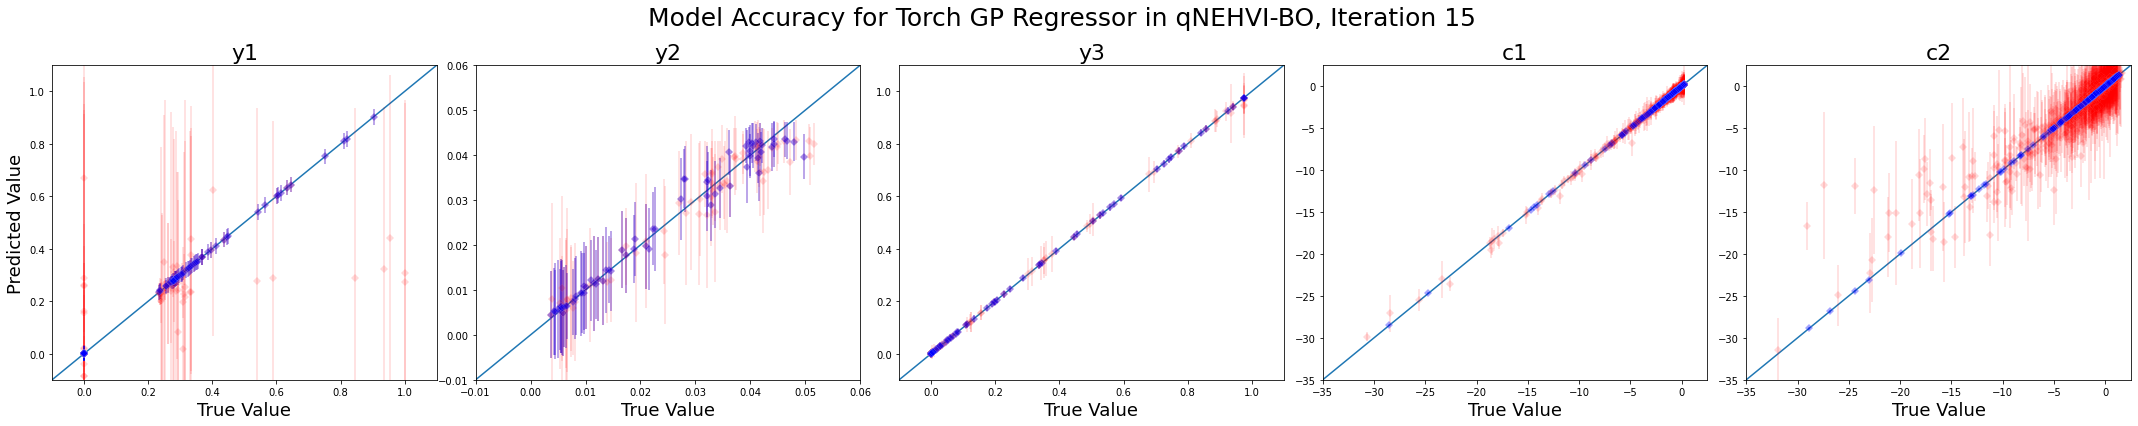

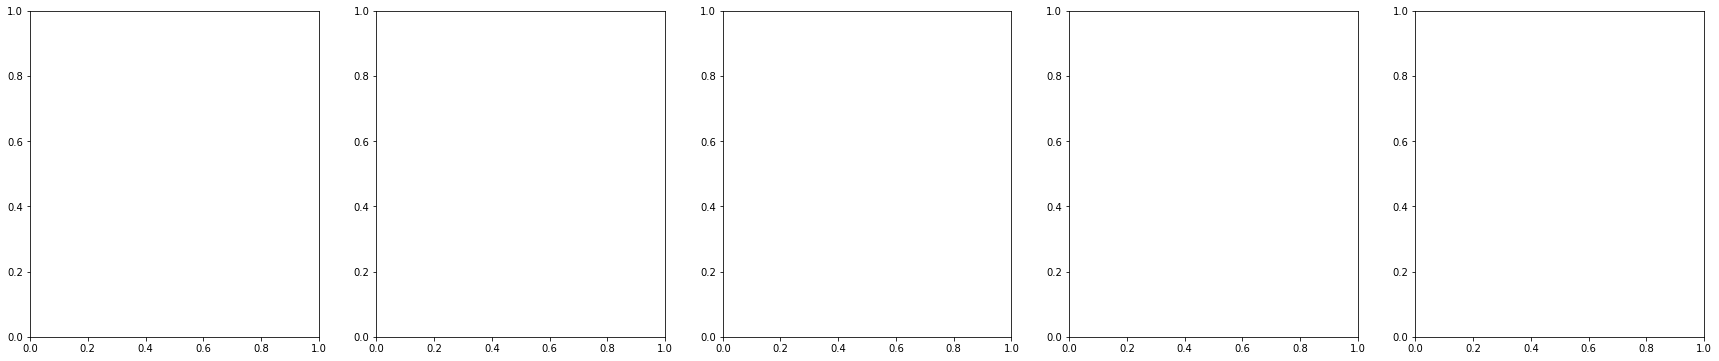

In [13]:
df = pd.read_csv('Results_Algo1_Run15.csv')

r2_list1,r2_list2,r2_list3,r2_list4,r2_list5 = [],[],[],[],[]

for current_iter in range(1,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]
    
    train_y = torch.hstack([train_obj, train_con])

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    

    model.eval();

    with torch.no_grad():
        # entire dataset
        posterior = model.posterior(train_x_all_gp)
        y_pred = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error = upper-lower
        
        # just the training set
        posterior = model.posterior(train_x_gp)
        y_pred1 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error1 = upper-lower
        
        # constraint - pre-trained added 256
        posterior = model.posterior(virtual_x_gp1)
        y_pred2 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error2 = upper-lower

        # constraint - testing on 1024
        posterior = model.posterior(fake_x_gp)
        y_pred3 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error3 = upper-lower    
        
    # record r2 scores for objective values
    for i,r2list in zip([0,1,2],
                        [r2_list1,r2_list2,r2_list3]
                        ):
        full_score = r2_score(train_y_all[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        train_score = r2_score(train_y[:,i].cpu().numpy(), y_pred1[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])
    
    # record r2 scores for constraint values
    for i, j, r2list in zip([3,4],
                            [0,1],
                            [r2_list4,r2_list5]
                           ):
        
        full_score = r2_score(fake_y[:,j].cpu().numpy(), y_pred3[:,i].cpu().numpy())
        train_score = r2_score(virtual_con1[:,j].cpu().numpy(), y_pred2[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])

    ####################
       
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
            
        fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

        # plot objective predictions
        for i, obj in zip([0,1,2],
                          ['y1', 'y2', 'y3'],
                          ):

            ax[i].axline((1, 1), slope=1)

            ax[i].errorbar(x=train_y_all[:,i].cpu().numpy(), y=y_pred[:,i].cpu().numpy(), yerr=error[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label='Full Dataset'
                           )
            
            ax[i].errorbar(x=train_y[:,i].cpu().numpy(), y=y_pred1[:,i].cpu().numpy(), yerr=error1[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                            label='Trained Points'
                           )            
            

            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
         
        # plot constraint predictions
        for i, j,  obj in zip([3,4],
                              [0,1],
                              ['c1', 'c2'],
                             ):

            ax[i].axline((1, 1), slope=1)

            # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
            ax[i].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label='Full Dataset'
                           )

            # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
            ax[i].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                        label='Pretrained Points'
                       )          
            
            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)

        # some settings for the overall plotting
        ax[0].set_ylabel('Predicted Value', fontsize=18)
        fig.suptitle(f'Model Accuracy for Torch GP Regressor in qNEHVI-BO, Iteration {current_iter}', fontsize=25)
        fig.tight_layout()

        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_ylim(-0.1, 1.1)
        
        ax[1].set_xlim(-0.01, 0.06)
        ax[1].set_ylim(-0.01, 0.06)
        
        ax[2].set_xlim(-0.1, 1.1)
        ax[2].set_ylim(-0.1, 1.1)
        
        ax[3].set_xlim(-35, 2.5)
        ax[3].set_ylim(-35, 2.5)
        
        ax[4].set_xlim(-35, 2.5)
        ax[4].set_ylim(-35, 2.5)
                
####################

# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

for i, obj, r2list in zip([0,1,2,3,4],
                          ['y1', 'y2', 'y3', 'c1', 'c2'],
                          [r2_list1,r2_list2,r2_list3,r2_list4,r2_list5]
                             ):

    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,0], linewidth=2, c='r')
    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,1], linewidth=2, c='b')

    ax[i].set_xlabel('Iterations', fontsize=18)
    ax[i].grid(True)
    
    ax[i].set_title(f"{obj}", fontsize=22)
    
    ax[i].set_xlim(1, 15)
    ax[i].set_ylim(-0.0, 1.05)

fig.suptitle(f'Model Accuracy for Torch GP Regressor in qNEHVI-BO', fontsize=25)    

fig.tight_layout()        
ax[0].set_ylabel('R2 Score', fontsize=18)

In [16]:
r2_list1,r2_list2,r2_list3,r2_list4,r2_list5

([[0.7169177758627094, 0.9823682251916835]],
 [[0.9637494056879328, 0.9734139949349221]],
 [[0.9998277527638804, 0.9999987385309758]],
 [[0.9961354784282207, 0.9999987021288127]],
 [[0.8567772813742809, 0.9999997895128372]])

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

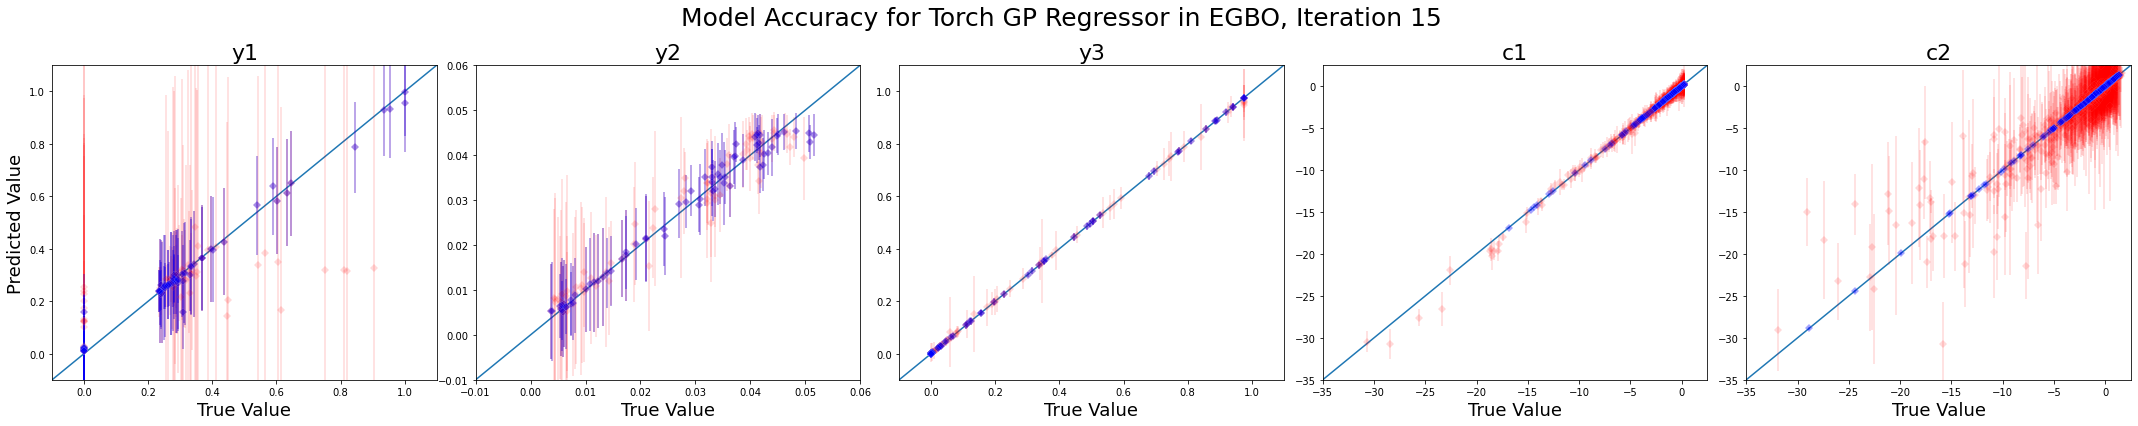

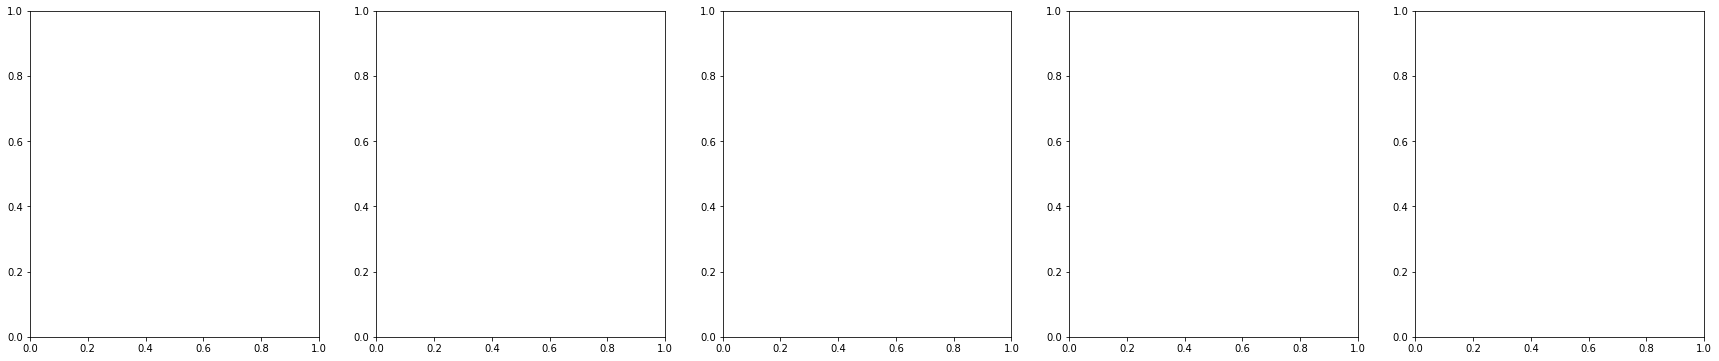

In [14]:
df = pd.read_csv('Results_Algo2_Run15.csv')

r2_list1,r2_list2,r2_list3,r2_list4,r2_list5 = [],[],[],[],[]

for current_iter in range(15,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)

    train_x = initial_x_torch[:,:n_var]
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    train_con = initial_x_torch[:,n_var+n_obj:n_var+n_obj+n_constr]
    
    train_y = torch.hstack([train_obj, train_con])

    ####################
    # surrogate model

    # define and train surrogate models for objective and constraint
    models = []

    # models for objective
    train_x_gp = normalize(train_x, problem_bounds)
    for i in range(train_obj.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))

    # for constraints, including extra virtual data
    input_file = "virtual_x_gp_256.csv"
    virtual_x_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_x_gp = torch.tensor(virtual_x_pandas.iloc[:,:].values, **tkwargs)

    input_file = "virtual_con_256.csv"
    virtual_con_pandas = pd.read_csv(f"{input_file}", delimiter=',', header=None) 
    virtual_con = torch.tensor(virtual_con_pandas.iloc[:,:].values, **tkwargs)

    virtual_x_gp1 = torch.vstack([train_x_gp, virtual_x_gp])
    virtual_con1 = torch.vstack([train_con, virtual_con])

    for i in range(virtual_con1.shape[-1]):
        models.append(SingleTaskGP(virtual_x_gp1, virtual_con1[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    

    model.eval();

    with torch.no_grad():
        # entire dataset
        posterior = model.posterior(train_x_all_gp)
        y_pred = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error = upper-lower
        
        # just the training set
        posterior = model.posterior(train_x_gp)
        y_pred1 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error1 = upper-lower
        
        # constraint - pre-trained added 256
        posterior = model.posterior(virtual_x_gp1)
        y_pred2 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error2 = upper-lower

        # constraint - testing on 1024
        posterior = model.posterior(fake_x_gp)
        y_pred3 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error3 = upper-lower    
        
    # record r2 scores for objective values
    for i,r2list in zip([0,1,2],
                        [r2_list1,r2_list2,r2_list3]
                        ):
        full_score = r2_score(train_y_all[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        train_score = r2_score(train_y[:,i].cpu().numpy(), y_pred1[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])
    
    # record r2 scores for constraint values
    for i, j, r2list in zip([3,4],
                            [0,1],
                            [r2_list4,r2_list5]
                           ):
        
        full_score = r2_score(fake_y[:,j].cpu().numpy(), y_pred3[:,i].cpu().numpy())
        train_score = r2_score(virtual_con1[:,j].cpu().numpy(), y_pred2[:,i].cpu().numpy())
        
        r2list.append([full_score, train_score])

    ####################
       
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
            
        fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

        # plot objective predictions
        for i, obj in zip([0,1,2],
                          ['y1', 'y2', 'y3'],
                          ):

            ax[i].axline((1, 1), slope=1)

            ax[i].errorbar(x=train_y_all[:,i].cpu().numpy(), y=y_pred[:,i].cpu().numpy(), yerr=error[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label='Full Dataset'
                           )
            
            ax[i].errorbar(x=train_y[:,i].cpu().numpy(), y=y_pred1[:,i].cpu().numpy(), yerr=error1[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                            label='Trained Points'
                           )            
            

            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)
         
        # plot constraint predictions
        for i, j,  obj in zip([3,4],
                              [0,1],
                              ['c1', 'c2'],
                             ):

            ax[i].axline((1, 1), slope=1)

            # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
            ax[i].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                           ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                            label='Full Dataset'
                           )

            # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
            ax[i].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                        label='Pretrained Points'
                       )          
            
            ax[i].set_title(f"{obj}", fontsize=22)
            ax[i].set_xlabel('True Value', fontsize=18)

        # some settings for the overall plotting
        ax[0].set_ylabel('Predicted Value', fontsize=18)
        fig.suptitle(f'Model Accuracy for Torch GP Regressor in EGBO, Iteration {current_iter}', fontsize=25)
        fig.tight_layout()

        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_ylim(-0.1, 1.1)
        
        ax[1].set_xlim(-0.01, 0.06)
        ax[1].set_ylim(-0.01, 0.06)
        
        ax[2].set_xlim(-0.1, 1.1)
        ax[2].set_ylim(-0.1, 1.1)
        
        ax[3].set_xlim(-35, 2.5)
        ax[3].set_ylim(-35, 2.5)
        
        ax[4].set_xlim(-35, 2.5)
        ax[4].set_ylim(-35, 2.5)
                
####################

# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

for i, obj, r2list in zip([0,1,2,3,4],
                          ['y1', 'y2', 'y3', 'c1', 'c2'],
                          [r2_list1,r2_list2,r2_list3,r2_list4,r2_list5]
                             ):

    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,0], linewidth=2, c='r')
    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,1], linewidth=2, c='b')

    ax[i].set_xlabel('Iterations', fontsize=18)
    ax[i].grid(True)
    
    ax[i].set_title(f"{obj}", fontsize=22)
    
    ax[i].set_xlim(1, 15)
    ax[i].set_ylim(-0.0, 1.05)

fig.suptitle(f'Model Accuracy for Torch GP Regressor in qNEHVI-BO', fontsize=25)    

fig.tight_layout()        
ax[0].set_ylabel('R2 Score', fontsize=18)

(-35.0, 2.5)

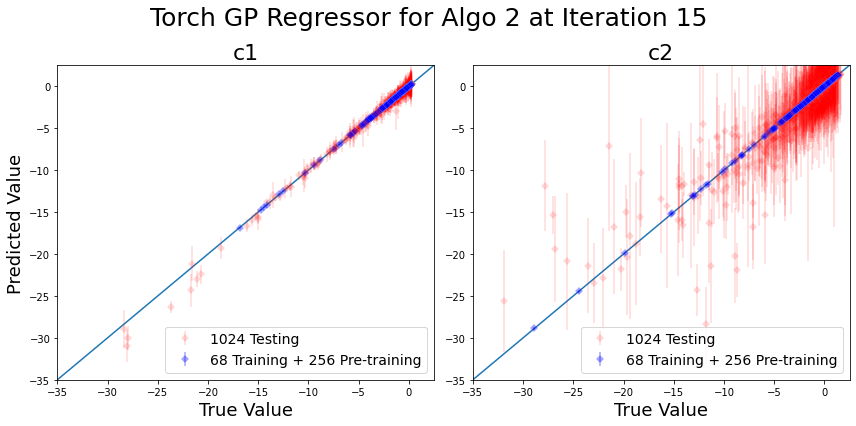

In [34]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

# plot constraint predictions
for i, j,  obj in zip([3,4], [0,1],
                      ['c1', 'c2'],
                     ):

    ax[j].axline((1, 1), slope=1)

    # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
    ax[j].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                   ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                    label=f'1024 Testing '
                   )

    # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
    ax[j].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
               ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                label=f'68 Training + 256 Pre-training'
               )          

    ax[j].set_title(f"{obj}", fontsize=22)
    ax[j].set_xlabel('True Value', fontsize=18)
    ax[j].legend(fontsize=14, loc='lower right')

# some settings for the overall plotting
ax[0].set_ylabel('Predicted Value', fontsize=18)
fig.suptitle(f'Torch GP Regressor for Algo 2 at Iteration 15', fontsize=25)
fig.tight_layout()

ax[0].set_xlim(-35, 2.5)
ax[0].set_ylim(-35, 2.5)

ax[1].set_xlim(-35, 2.5)
ax[1].set_ylim(-35, 2.5)

####################


In [ ]:

# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 5, figsize = (30,6))

for i, obj, r2list in zip([0,1,2,3,4],
                  ['y1', 'y2', 'y3', 'c1', 'c2'],
                  [r2_list1,r2_list2,r2_list3,r2_list4,r2_list5]
                     ):

    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,0], linewidth=2, c='r')
    ax[i].plot(np.arange(1,15+1), np.array(r2list)[:,1], linewidth=2, c='b')

    ax[i].set_xlabel('Iterations', fontsize=18)
    ax[i].grid(True)

    ax[i].set_title(f"{obj}", fontsize=22)

    ax[i].set_xlim(1, 15)
    ax[i].set_ylim(-0.0, 1.05)

fig.suptitle(f'Model Accuracy for Torch GP Regressor for Algo 1', fontsize=25)    

fig.tight_layout()        
ax[0].set_ylabel('R2 Score', fontsize=18)

(-35.0, 2.5)

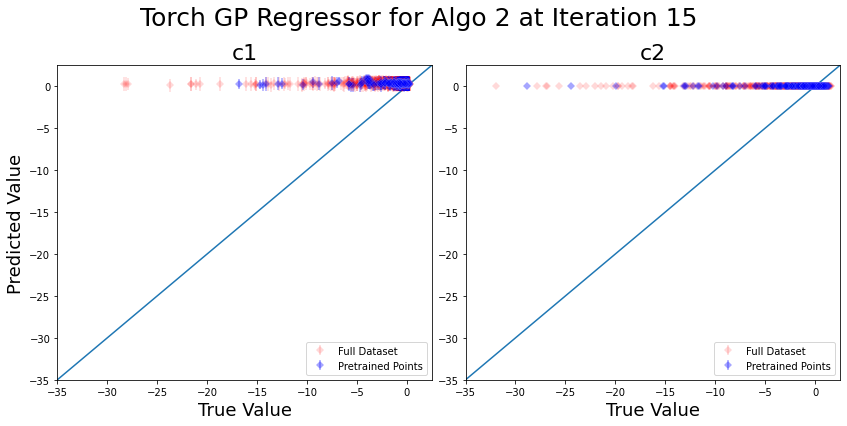

In [12]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

# plot constraint predictions
for i, j,  obj in zip([0,1],
                      [0,1],
                      ['c1', 'c2'],
                     ):

    ax[i].axline((1, 1), slope=1)

    # note that fake_y has only N_CONSTR columns, so we use a new jth index to call it
    ax[i].errorbar(x=fake_y[:,j].cpu().numpy(), y=y_pred3[:,i].cpu().numpy(), yerr=error3[:,i].cpu().numpy(),
                   ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                    label='Full Dataset'
                   )

    # note that virtual_con has only N_CONST columns, so we use a new jth index to call it
    ax[i].errorbar(x=virtual_con1[:,j].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
               ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                label='Pretrained Points'
               )              

    ax[i].set_title(f"{obj}", fontsize=22)
    ax[i].set_xlabel('True Value', fontsize=18)
    
    ax[i].legend()

# some settings for the overall plotting
ax[0].set_ylabel('Predicted Value', fontsize=18)
fig.suptitle(f'Torch GP Regressor for Algo 2 at Iteration 15', fontsize=25)
fig.tight_layout()


ax[0].set_xlim(-35, 2.5)
ax[0].set_ylim(-35, 2.5)

ax[1].set_xlim(-35, 2.5)
ax[1].set_ylim(-35, 2.5)

In [2]:
BATCH_SIZE = 4
n_var = 5
n_obj = 3
n_constr = 2

####################
# normalization

# normalize inputs to [0,1] first before feeding into model
problem_bounds = torch.zeros(2, n_var, **tkwargs)
problem_bounds[0] = 0.6
problem_bounds[1] = 24.0

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

####################
random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

# testing for constraints
test_x = draw_sobol_samples(bounds=problem_bounds,n=1024, q=1).squeeze(1)
test_x_gp = normalize(test_x, problem_bounds)
test_y1 = 0.3 - test_x[:,1]/test_x[:,4]
test_y2 = 2 - (test_x[:,1]/test_x[:,4]) - (test_x[:,3]/test_x[:,1])
test_y = torch.hstack([test_y1.unsqueeze(1), test_y2.unsqueeze(1)])

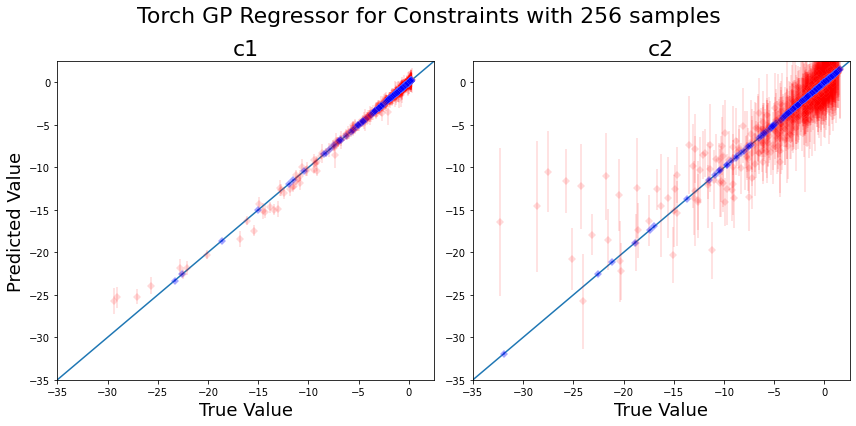

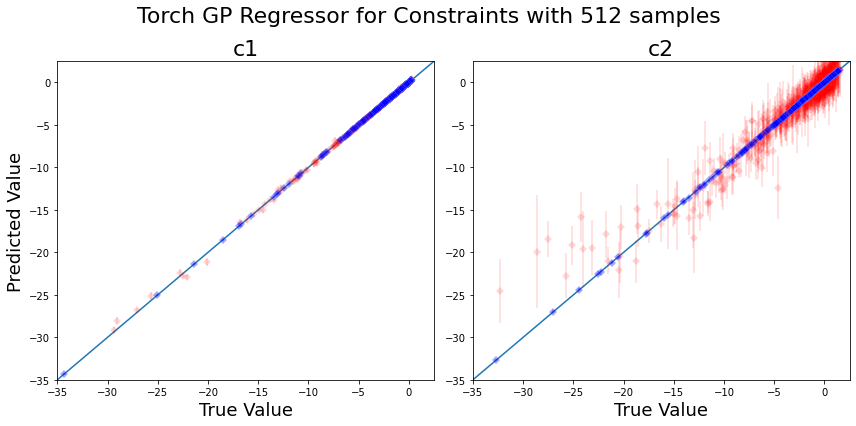

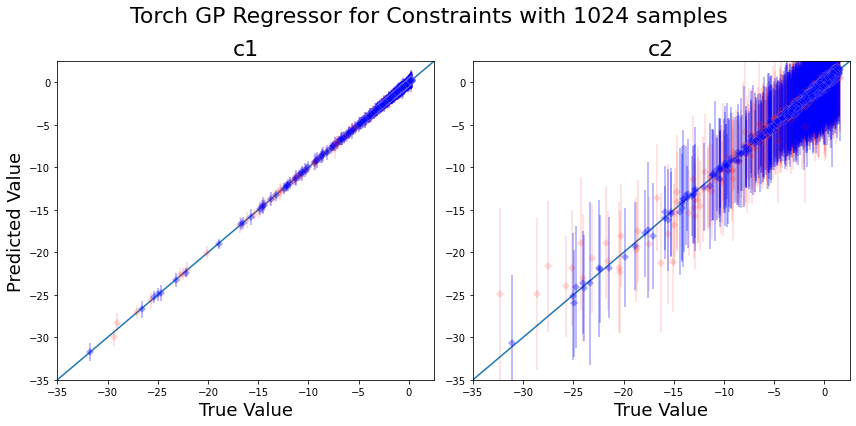

In [19]:
random_state = 1
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

r2_list1, r2_list2 = [], []

for num_samples in [256, 512, 1024]:

    ####################
    # testing for constraints
    fake_x = draw_sobol_samples(bounds=problem_bounds,n=num_samples, q=1).squeeze(1)
    fake_x_gp = normalize(fake_x, problem_bounds)
    fake_y1 = 0.3 - fake_x[:,1]/fake_x[:,4]
    fake_y2 = 2 - (fake_x[:,1]/fake_x[:,4]) - (fake_x[:,3]/fake_x[:,1])
    fake_y = torch.hstack([fake_y1.unsqueeze(1), fake_y2.unsqueeze(1)])

    models = []

    for i in range(fake_y.shape[-1]):
        models.append(SingleTaskGP(fake_x_gp, fake_y[..., i : i + 1], outcome_transform=Standardize(m=1)))

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll) 

    ####################    

    model.eval();

    with torch.no_grad():
        # training set
        posterior = model.posterior(fake_x_gp)
        y_pred1 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error1 = upper-lower

        # test set
        posterior = model.posterior(test_x_gp)
        y_pred2 = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        error2 = upper-lower


    # record r2 scores for objective values
    for i,r2list in zip([0,1],
                        [r2_list1,r2_list2]
                        ):

        train_score = r2_score(fake_y[:,i].cpu().numpy(), y_pred1[:,i].cpu().numpy())
        test_score = r2_score(test_y[:,i].cpu().numpy(), y_pred2[:,i].cpu().numpy())

        r2list.append([test_score, train_score])

    ####################

    fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

    # plot objective predictions
    for i, obj in zip([0,1],
                      ['c1', 'c2'],
                      ):

        ax[i].axline((1, 1), slope=1)

        ax[i].errorbar(x=test_y[:,i].cpu().numpy(), y=y_pred2[:,i].cpu().numpy(), yerr=error2[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', alpha=0.15,
                        label='Test set'
                       )

        ax[i].errorbar(x=fake_y[:,i].cpu().numpy(), y=y_pred1[:,i].cpu().numpy(), yerr=error1[:,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='b', c='b', alpha=0.35,
                        label='Train set'
                       )            


        ax[i].set_title(f"{obj}", fontsize=22)
        ax[i].set_xlabel('True Value', fontsize=18)

        ax[i].set_xlim(-35, 2.5)
        ax[i].set_ylim(-35, 2.5)


        # some settings for the overall plotting
        ax[0].set_ylabel('Predicted Value', fontsize=18)
        fig.suptitle(f'Torch GP Regressor for Constraints with {num_samples} samples', fontsize=22)
        fig.tight_layout()

Text(68.25, 0.5, 'R2 Score')

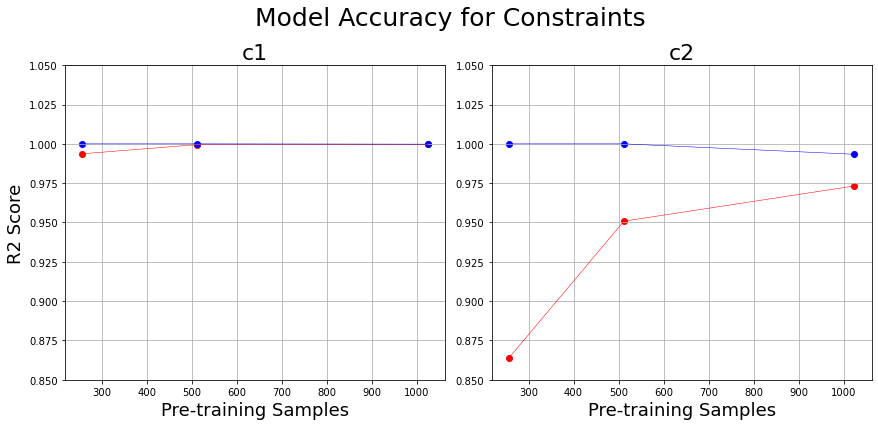

In [25]:
####################

# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

for i, obj, r2list in zip([0,1],
                      ['c1', 'c2'],
                      [r2_list1,r2_list2]
                         ):

    ax[i].plot(np.array([256, 512, 1024]), np.array(r2list)[:,0], linewidth=0.5, c='r')
    ax[i].plot(np.array([256, 512, 1024]), np.array(r2list)[:,1], linewidth=0.5, c='b')
    
    ax[i].scatter(np.array([256, 512, 1024]), np.array(r2list)[:,0], c='r')
    ax[i].scatter(np.array([256, 512, 1024]), np.array(r2list)[:,1], c='b')

    ax[i].set_xlabel('Pre-training Samples', fontsize=18)
    ax[i].grid(True)

    ax[i].set_title(f"{obj}", fontsize=22)

    #ax[i].set_xlim(1, 15)
    ax[i].set_ylim(0.85, 1.05)

fig.suptitle(f'Model Accuracy for Constraints', fontsize=25)    

fig.tight_layout()        
ax[0].set_ylabel('R2 Score', fontsize=18)

In [2]:
from scipy.stats import qmc

Text(0, 0.5, 'Discrepancy')

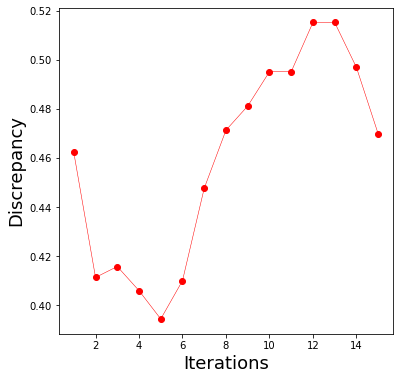

In [14]:
BATCH_SIZE = 4
n_var = 5
n_obj = 3

df = pd.read_csv('Results_Algo2_Run15.csv')

dis_list = []

for current_iter in range(1,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]

    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]

    temp_candidate = pareto_y.cpu().numpy()
    discrepancy = qmc.discrepancy(temp_candidate)
    dis_list.append(discrepancy) # positive since we want lowest value   
    
# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 1, figsize = (6,6))

ax.plot(np.arange(1,15+1), dis_list, linewidth=0.5, c='r')
    
ax.scatter(np.arange(1,15+1), dis_list, c='r')

ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Discrepancy', fontsize=18)

#fig.suptitle(f'Model Accuracy for Constraints', fontsize=25)    
#fig.tight_layout()        


Text(0, 0.5, 'Discrepancy')

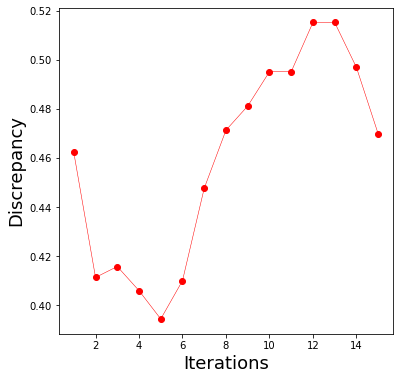